* This is a dataset with 100 individuals having `a=.25 and b=5.` propensities. 
* Surveyed `10` times, and we observed '7' individuals.

* True arrival/dep/props are in TH variable
    
* The arrival/dep rates:

         array([0.4       , 0.06666667, 0.06666667, 0.06666667, 0.06666667,
                0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667])

         array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1. ])
        
The model finds a better likelihood Here:

    Total Unseen: 50 / Likelihood: -19.1886

True reponse should be:

    Total Unseen: 93 / Likelihood: -20.7003

Note that Panos's MLE yields:
    
    21.701 /  1.049 /  2.442 /  0.599 /  0.267 /  4.660: 100%|██████████| 5000/5000 [00:15<00:00, 318.10it/s]
    
    arr, dep = (array([0.59868766, 0.04459026, 0.04459026, 0.04459026, 0.04459026,
        0.04459026, 0.04459026, 0.04459026, 0.04459026, 0.04459026]),
     array([0.2665464, 0.2665464, 0.2665464, 0.2665464, 0.2665464, 0.2665464,
        0.2665464, 0.2665464, 0.2665464, 0.2665464]))

In [28]:
%matplotlib inline
from tqdm import tqdm
import pandas as pd
import numpy as np
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.transforms import t_stick_breaking

In [44]:
import pickle
with open('data/gch-100-10-0.25-5.00.pkl', 'rb') as f:
  GCH, TH = pickle.load(f)
S = 10
npdata = np.array(GCH, dtype = int)
V = len(GCH)
V, type(V)

(7, int)

In [45]:
def get_vmask():
    v_mask = np.zeros([S,S,S])
    for s in np.arange(S):
        for q in np.arange(s,S):
            c1 = np.zeros(s)
            c2 = np.ones(q-s)
            c3 = np.zeros(S-q)
            v_mask[s,q]= np.concatenate((c1, c2, c3))
    return tt.constant(v_mask)

In [46]:
def get_imask():
    s_mask = np.zeros([V,S])
    q_mask = np.zeros([V,S])
    for w in np.arange(V):
        f, l = npdata[w, 0] , npdata[w, 1]
        s_mask[w] = np.concatenate((np.ones(f+1), np.zeros(S - f -1)))
        q_mask[w] = np.concatenate((np.zeros(l), np.ones(S-l)))
    i_mask = np.einsum("is,iq->isq", s_mask, q_mask)
    return tt.constant(i_mask)

In [36]:
def get_Risq(a,b):
    tmp_u = npdata[:, 2]
    expanded_u = tmp_u[:, np.newaxis, np.newaxis] *  np.ones((V, S, S)) # V x S x S
    d = np.broadcast_to(np.triu(np.ones([S,S]), 0).cumsum(axis =1), (V, S, S)) # V x S x S
    n = tt.constant(np.clip(d,a_min=0,a_max=S+1))
    n_u = np.triu(d - expanded_u, 0)
    n_u = tt.constant(np.clip(n_u,a_min=0,a_max=max(tmp_u))) # V x S x S
   
    
    # The beta binomial
    R_isq =   tt.gammaln(n+1)
    R_isq -=  tt.gammaln(expanded_u+1)
    R_isq -=  tt.gammaln(n_u+1)   
    R_isq +=  tt.gammaln(expanded_u+a)
    R_isq +=  tt.gammaln(n_u+b)
    R_isq -=  tt.gammaln(n+a+b)
    R_isq +=  tt.gammaln(a+b) - tt.gammaln(a) - tt.gammaln(b)

    # The above is the computation of the log, so we take the exponent
    return tt.exp(R_isq)

In [37]:
def get_Risq0(a,b):
    # n = q - s + 1
    n = tt.constant(np.triu(np.ones([S,S]), 0).cumsum(axis =1))
    R0_sq = tt.gammaln(n + b) - tt.gammaln(n + a + b) + tt.gammaln(a + b) - tt.gammaln(b)
    return tt.exp(R0_sq)

In [51]:
def logp_capture(arr, phi, a, b, U):
    def ll_capture_f(mycaptures):
        
        # Masks: try to compute these once.
        phi_mask = get_vmask()  # S x S x S . all possible arrivals and departures for the "SURVIVAL"
        i_mask   = get_imask()  # KxK   . matrix with real possible arrival and departures
        R_isq = get_Risq(a, b) #
        R0_sq = get_Risq0(a, b) #
        
        # Likelihood of Capture Li
        phi_v = tt.pow(1-phi, phi_mask)
        phi_v = tt.prod(phi_v, axis=2)
        LD = arr[:, np.newaxis] * phi_v * phi
        LD_isq = tt.mul(LD, i_mask)
        Li = tt.batched_tensordot(LD_isq, R_isq, axes = 2)
        
        # Likelihood of No-Capture L0
        v0_mask = 1 - phi_mask[0] # tihs is reuse
        LD0 = tt.mul(LD, v0_mask)
        L0 = tt.sum(LD0 * R0_sq)
        
        # Multinomial
        obj1 = tt.gammaln(tt.constant(V)+U+1.0) - tt.gammaln(U+1.0) - tt.gammaln(tt.constant(V)+ 1.0) #
        obj2 = tt.sum(tt.log(Li))
        obj3 = U * tt.log(L0)

        objective = obj1 + obj2 + obj3 
        
        return objective
    
    return ll_capture_f

In [65]:
birth_init, dep = (np.array([0.4       , 0.06666667, 0.06666667, 0.06666667, 0.06666667,
          0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667]),
 np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1. ]))
for UU in range(0, 100, 1):
    print("Total Unseen:", UU, "/ Likelihood:", logp_capture(birth_init, dep, .25,  5., UU)(npdata).eval().round(4))

INFO (theano.gof.compilelock): Refreshing lock /Users/ded/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir/lock


Total Unseen: 0 / Likelihood: -32.0524
Total Unseen: 1 / Likelihood: -30.1035
Total Unseen: 2 / Likelihood: -28.73
Total Unseen: 3 / Likelihood: -27.6566
Total Unseen: 4 / Likelihood: -26.7756
Total Unseen: 5 / Likelihood: -26.0307
Total Unseen: 6 / Likelihood: -25.3881
Total Unseen: 7 / Likelihood: -24.8256
Total Unseen: 8 / Likelihood: -24.3275
Total Unseen: 9 / Likelihood: -23.8827
Total Unseen: 10 / Likelihood: -23.4827
Total Unseen: 11 / Likelihood: -23.1208
Total Unseen: 12 / Likelihood: -22.7919
Total Unseen: 13 / Likelihood: -22.4917
Total Unseen: 14 / Likelihood: -22.2168
Total Unseen: 15 / Likelihood: -21.9644
Total Unseen: 16 / Likelihood: -21.7321
Total Unseen: 17 / Likelihood: -21.5178
Total Unseen: 18 / Likelihood: -21.3199
Total Unseen: 19 / Likelihood: -21.1368
Total Unseen: 20 / Likelihood: -20.9673
Total Unseen: 21 / Likelihood: -20.8102
Total Unseen: 22 / Likelihood: -20.6645
Total Unseen: 23 / Likelihood: -20.5294
Total Unseen: 24 / Likelihood: -20.404
Total Unseen:

In [55]:
# custom log-liklihood
# model
with pm.Model() as model:
    # parameters
    U = pm.DiscreteUniform('Unseen', lower=V, upper=5*S)
    a = pm.Uniform('alpha', 0., 1.)
    b = pm.Uniform('beta', 2, 10)
    phi    = pm.Uniform('departure', 0., 1., shape=S)
    arr    = pm.Dirichlet('arrival', a=np.array([1./S]*S), shape=S)
    
    # Model Log-likelihood
    ob = pm.DensityDist('x', logp_capture(arr, phi, a, b, U), observed=npdata)

In [58]:
with model:
    fmap = pm.find_MAP()
fmap

logp = 1,378.9, ||grad|| = 8.2269e-05: 100%|██████████| 21/21 [00:00<00:00, 275.27it/s]  


{'Unseen': array(28),
 'alpha_interval__': array(23.8996075),
 'beta_interval__': array(-103.4268363),
 'departure_interval__': array([-100.4267054 , -130.81440015,  -82.15126784,  -44.96449469,
         -66.74008855,  -29.04330439,  -40.5913483 ,  -58.28847038,
         -17.72496499,  205.25445564]),
 'arrival_stickbreaking__': array([240.59322567, 143.76242581, 136.07524198, 120.97451421,
         87.54437402,  73.53415947,  88.60408371,  68.20276358,
         45.343802  ]),
 'alpha': array(1.),
 'beta': array(2.),
 'departure': array([2.42792916e-44, 1.54179935e-57, 2.09970217e-36, 2.96597902e-20,
        1.03549456e-29, 2.43586472e-13, 2.35180560e-18, 4.84885231e-26,
        2.00514372e-08, 1.00000000e+00]),
 'arrival': array([1.00000000e+000, 2.22044605e-016, 4.93038066e-032, 1.09476443e-047,
        2.43086534e-063, 5.39760535e-079, 1.19850915e-094, 2.66122490e-110,
        5.90910632e-126, 1.31208518e-141])}

In [66]:
with model:
  #posterior = pm.sample(3, tune=0, chains=1, progressbar=False)
  #step = pm.NUTS()
  #posterior = pm.sample(100000, step=step, njobs = 4)
  posterior = pm.sample(100000, chains = 1 , cores = 1)

INFO (theano.gof.compilelock): Refreshing lock /Users/ded/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [Unseen]
>NUTS: [arrival, departure, beta, alpha]
100%|██████████| 100500/100500 [1:52:38<00:00, 14.87it/s]
There were 15532 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8990024626762478, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


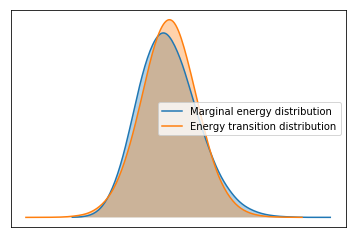

In [67]:
pm.energyplot(posterior);

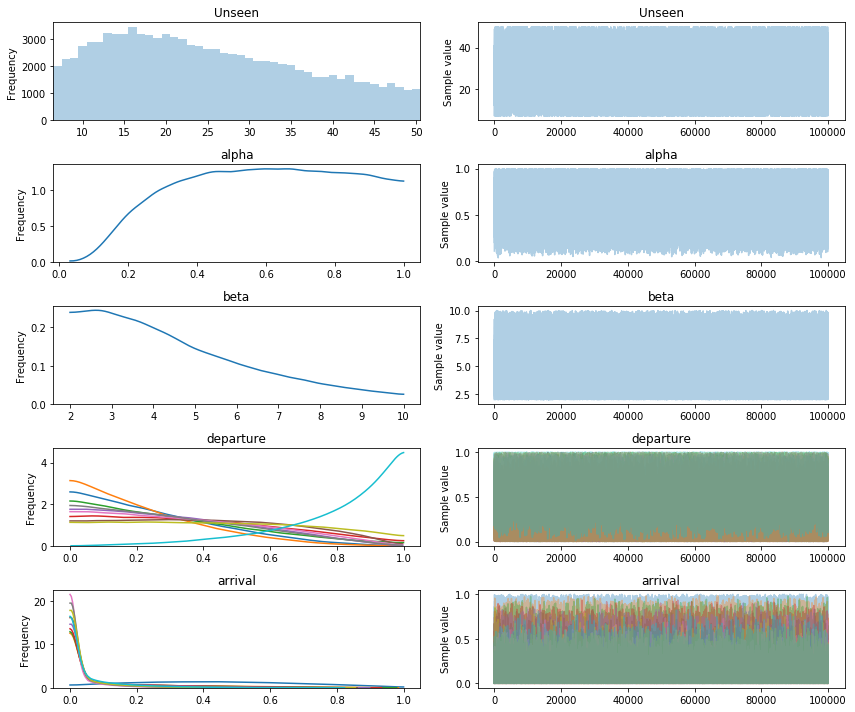

In [68]:
pm.traceplot(posterior);

In [18]:
pm.summary(posterior).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Unseen,36.28,9.12,0.39,20.00,50.00
alpha,0.63,0.21,0.00,0.29,1.00
beta,4.25,1.64,0.04,2.00,7.47
departure__0,0.50,0.29,0.00,0.05,1.00
departure__1,0.45,0.28,0.00,0.01,0.94
departure__2,0.37,0.26,0.00,0.00,0.86
departure__3,0.26,0.22,0.00,0.00,0.71
departure__4,0.24,0.18,0.00,0.00,0.59
departure__5,0.23,0.18,0.00,0.00,0.60
departure__6,0.18,0.15,0.00,0.00,0.49
